Import libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import PreTrainedTokenizerFast
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from nltk.corpus import stopwords
import math
import sys
import os

# Workaround for python's terrible package management system
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("model"), '..')))

from util.calc_acc_metrics import calc_acc_metrics
from util.calc_loss_and_acc import calc_loss_and_acc
from util.plot_metrics import plot_metrics

c:\Users\Javid\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create pytorch dataset 

In [2]:
class MovieDataset(Dataset):
    
    def __init__(self,tokenizer):
        self.tokenizer = tokenizer
        self.corpus = pd.read_csv('../util/IMDB Dataset.csv')
        self.corpus.drop_duplicates(inplace=True) 
        self.corpus = self.corpus.to_numpy()
        self.stop_words = set(stopwords.words("english"))
        self.X_train = self.corpus[:,0]
        self.Y_train = self.corpus[:,1]

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        filtered_words = [] 
        sentences = self.X_train[index].lower().split()
        for word in sentences:
            if(word not in self.stop_words):
                filtered_words.append(word)
                filtered_words.append(" ")
        filtered_words.pop()
        cleaned_str = ''.join(filtered_words)
        tokens = self.tokenizer(cleaned_str, max_length=150, padding='max_length',
                        truncation=True, return_tensors="pt")
        input_ids = tokens.input_ids.squeeze(0)
        label = 0 if self.Y_train[index] == "negative" else 1
        return input_ids, label

In [3]:
class LSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size + 1, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1, :, :]
        drop = self.drop(hidden)
        output = self.fc(drop)
        return output

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = PreTrainedTokenizerFast(tokenizer_file="../tokenizer/tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '<pad>'})

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 128
HIDDEN_DIM = 100
OUTPUT_DIM = 2
NUM_EPOCHS = 10
BATCH_SIZE = 50
SEED = torch.seed()
torch.manual_seed(SEED)

model = LSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

ds = MovieDataset(tokenizer)

length = ds.__len__()
train_size = math.floor(0.8 * length)
valid_size = math.ceil(0.1* length)
test_size = math.floor(0.1 * length)

train, valid, test = random_split(ds, [train_size,valid_size,test_size])
train_loader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid, shuffle=False)
test_loader = DataLoader(test, shuffle=False)

In [4]:
def train():
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = calc_loss_and_acc(model,optimizer,train_loader,criterion,device,train=True)

        with torch.no_grad():
            valid_loss, valid_acc = calc_loss_and_acc(model,optimizer,valid_loader,criterion,device,train=False)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid Loss: {valid_loss:.4f}")
        
    return train_losses, valid_losses, train_accs, valid_accs

print("Seed",SEED)

train_losses, valid_losses, train_accs, valid_accs = train()

Seed 1335281176793100
Epoch 1/10, Train acc: 0.5063, Train Loss: 0.6961, Valid Acc: 0.5991, Valid Loss: 0.6683
Epoch 2/10, Train acc: 0.6080, Train Loss: 0.6559, Valid Acc: 0.6941, Valid Loss: 0.6124
Epoch 3/10, Train acc: 0.7355, Train Loss: 0.5491, Valid Acc: 0.7756, Valid Loss: 0.5113
Epoch 4/10, Train acc: 0.8284, Train Loss: 0.4091, Valid Acc: 0.7846, Valid Loss: 0.4853
Epoch 5/10, Train acc: 0.8527, Train Loss: 0.3652, Valid Acc: 0.7864, Valid Loss: 0.4808
Epoch 6/10, Train acc: 0.8855, Train Loss: 0.2983, Valid Acc: 0.8064, Valid Loss: 0.4895
Epoch 7/10, Train acc: 0.9072, Train Loss: 0.2539, Valid Acc: 0.7917, Valid Loss: 0.5409
Epoch 8/10, Train acc: 0.9163, Train Loss: 0.2339, Valid Acc: 0.7990, Valid Loss: 0.5033
Epoch 9/10, Train acc: 0.9136, Train Loss: 0.2382, Valid Acc: 0.8125, Valid Loss: 0.4804
Epoch 10/10, Train acc: 0.9226, Train Loss: 0.2161, Valid Acc: 0.8066, Valid Loss: 0.4892


Test Loss: 0.4820, Test Accuracy: 0.8110, F1: 0.8228, Recall: 0.8770, Precision: 0.7748


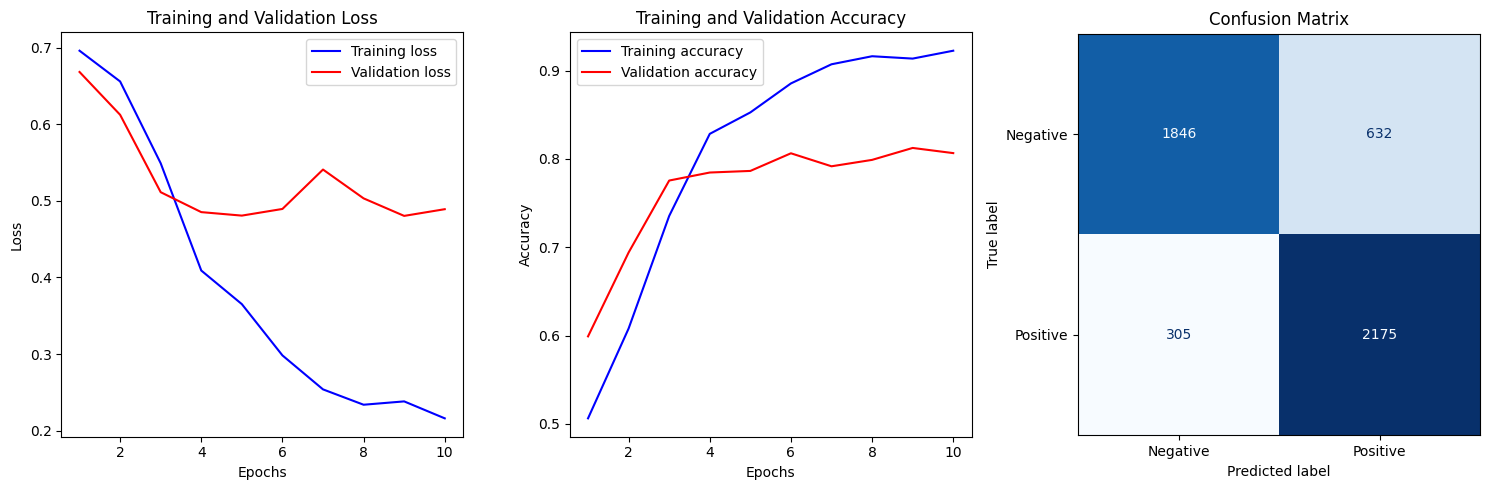

In [5]:
with torch.no_grad():
    test_loss, test_accuracy = calc_loss_and_acc(model,optimizer,test_loader,criterion,device,train=False)
    f1, recall, precision, confusion_mat = calc_acc_metrics(model, test_loader, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
plot_metrics(train_losses, valid_losses, train_accs, valid_accs, confusion_mat)